In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',
    
    # 同時保留大小類別可能是冗長的
    # 小類別
    # '道路型態子類別名稱', '事故位置子類別名稱',
    # '車道劃分設施-分向設施子類別名稱', 
    # '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要', '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱',
    # '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別', 
    
    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

# 每個月各取2萬筆
# dist_dfA2 = dist_dfA2.groupby('發生月份').apply(lambda x: x.sample(n=min(len(x), 20000), random_state=42)).reset_index(drop=True)

# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

In [4]:
from sklearn.utils import resample

sampling_ratio = 0.5

# 計算 A1 和 A2 原始數據量比例
A1_total = len(dist_dfA1)
A2_total = len(dist_dfA2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(dist_dfA1, dist_dfA2, sampling_ratio, total_ratio)

# 檢查結果
print(f"下採樣前 A1 資料量：{len(dist_dfA1)} / 下採樣後 A1 資料量：{len(downsampled_A1)}")
print(f"下採樣前 A1 資料量：{len(dist_dfA2)} / 下採樣後 A2 資料量： {len(downsampled_A2)}")
print("舊 A1/A2 比例：", len(dist_dfA1) / len(dist_dfA2))
print("新 A1/A2 比例：", len(downsampled_A1) / len(downsampled_A2))

# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

74
16962
79
18109
67
15358
56
12836
60
13753
64
14670
75
17192
71
16275
65
14899
78
17879
下採樣前 A1 資料量：1383 / 下採樣後 A1 資料量：689
下採樣前 A1 資料量：317023 / 下採樣後 A2 資料量： 157933
舊 A1/A2 比例： 0.004362459506092618
新 A1/A2 比例： 0.004362609460973958


In [5]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

dummy_data: (158622, 174)


In [6]:
rbind_data['肇因研判大類別名稱-個別'].value_counts()

肇因研判大類別名稱-個別
駕駛者            123306
其他              22659
無(車輛駕駛者因素)       8399
非駕駛者             1534
未紀錄               683
機件                519
燈光                419
裝載                397
無(物或動物)           338
無(非車輛駕駛人因素)       330
交通管制(設施)           38
Name: count, dtype: int64

In [37]:
rbind_data = rbind_data[(rbind_data['肇因研判大類別名稱-個別']!='駕駛者') & 
                        (rbind_data['肇因研判大類別名稱-個別']!='其他') &
                        (rbind_data['肇因研判大類別名稱-個別']!='無(車輛駕駛者因素)')]
dummy_data = pd.get_dummies(rbind_data)

rbind_data.shape

(4258, 32)

In [13]:
data_for_kmode = rbind_data.drop(['死亡', '受傷'], axis=1)

In [14]:
from kmodes.kmodes import KModes

In [15]:
cost = []
all_results = {}
K = range(1, 10)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=5
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Init: initializing centroidsInit: initializing centroids
Init: initializing centroids

Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 48114.0
Run 1, iteration: 1/100, moves: 0, cost: 48114.0
Run 2, iteration: 1/100, moves: 0, cost: 48114.0
Init: initializing centroids
Init: initializing centroids
Run 4, iteration: 1/100, moves: 0, cost: 48114.0
Init: initializing centroids
Run 3, iteration: 1/100, moves: 0, cost: 48114.0
Init: initializing clusters
Init: initializing centroids
Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
S

### info
1. kmode_datas：整筆資料進行k-mode（30w）
2. kmode_datas_undersample：下採樣的k-mode （15w）

In [10]:
file_path = "/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Calculated/kmode_datas_undersample.pkl"

# with open(file_path, 'wb') as file:
#     pickle.dump(all_results, file)

with open(file_path, 'rb') as f:
    all_results = pickle.load(f)

In [12]:
# plt.figure(figsize=(8, 5))
# plt.plot(K, cost, marker='o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Cost')
# plt.title('Elbow Method for Optimal k')
# plt.show()

In [13]:
pd.Series(all_results[4]['labels']).value_counts()
# pd.Series(optimal_result['labels']).value_counts()

2    45043
1    43507
3    36035
0    34037
Name: count, dtype: int64

In [14]:
rbind_data['Cluster'] = all_results[4]['labels']
rbind_data.head()

,天候名稱,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,路面狀況-路面鋪裝名稱,路面狀況-路面狀態名稱,路面狀況-路面缺陷名稱,道路障礙-障礙物名稱,道路障礙-視距品質名稱,道路障礙-視距名稱,...,事故類型及型態大類別名稱,肇因研判大類別名稱-主要,當事者區分-類別-大類別名稱-車種,當事者行動狀態大類別名稱,車輛撞擊部位大類別名稱-最初,車輛撞擊部位大類別名稱-其他,肇因研判大類別名稱-個別,死亡,受傷,Cluster
0,晴,有照明且開啟,村里道路,61-70,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車輛本身,其他,機車,車的狀態,機車與自行車,未紀錄,其他,1,0,2
1,晴,有照明且開啟,國道,91-100,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車與車,駕駛者,小客車(含客、貨兩用),車的狀態,汽車,汽車,駕駛者,1,1,0
2,晴,有照明未開啟或故障,市區道路,51-60,柏油,乾燥,無缺陷,無障礙物,有遮蔽物,路上停放車輛,...,車與車,駕駛者,機車,車的狀態,機車與自行車,未紀錄,駕駛者,1,1,2
3,晴,無照明,市區道路,61-70,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,車與車,駕駛者,機車,車的狀態,機車與自行車,未紀錄,駕駛者,1,1,1
4,晴,有照明未開啟或故障,市區道路,51-60,柏油,乾燥,無缺陷,無障礙物,無遮蔽物,良好,...,人與車,駕駛者,小貨車(含客、貨兩用),車的狀態,汽車,未紀錄,駕駛者,1,0,1


In [15]:
clusters = {}
for cluster_id in sorted(rbind_data['Cluster'].unique()):
    clusters[cluster_id] = rbind_data[rbind_data['Cluster'] == cluster_id]

for cluster_id, cluster_data in clusters.items():
    file_path = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_{cluster_id}.csv"
    cluster_data.to_csv(file_path, index=False)
    print(f"群體 {cluster_id} 的資料已保存到 {file_path}")

群體 0 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_0.csv
群體 1 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_1.csv
群體 2 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_2.csv
群體 3 的資料已保存到 /Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_3.csv


In [7]:
c0 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_0.csv", low_memory=False)
c1 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_1.csv", low_memory=False)
c2 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_2.csv", low_memory=False)
c3 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_3.csv", low_memory=False)
# c4 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_4.csv", low_memory=False)
# c5 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_5.csv", low_memory=False)
# c6 = pd.read_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/KmodeData/Undersample/cluster_6.csv", low_memory=False)

In [ ]:
for i in range(4):
    C_n = rbind_data[rbind_data['Cluster']==i]
    print(C_n['肇因研判大類別名稱-個別'].value_counts(normalize=True))
    print('-------------------------------------------------------')

In [24]:
result = compare_categorical_features(c0.drop(['Cluster'], axis=1), 
                                      c1.drop(['Cluster'], axis=1))
# result.sort_values(by="chi2", ascending=False)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = dummy_data
y = optimal_result['labels']

X_train, X_test, y_train, y_test = train_test_split(dummy_data, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 特征重要性排序
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

In [26]:
feature_importances

,Feature,Importance
105,道路型態大類別名稱_交岔路,5.864754e-02
109,事故位置大類別名稱_交叉路口,5.478570e-02
107,道路型態大類別名稱_單路部分,5.453985e-02
129,當事者區分-類別-大類別名稱-車種_人,4.240864e-02
112,事故位置大類別名稱_路段,4.150715e-02
...,...,...
5,天候名稱_霧或煙,4.718277e-08
35,路面狀況-路面鋪裝名稱_碎石,1.230280e-08
99,行動電話或電腦或其他相類功能裝置名稱_使用免持或未有礙駕駛安全,0.000000e+00
142,當事者區分-類別-大類別名稱-車種_特種車,0.000000e+00


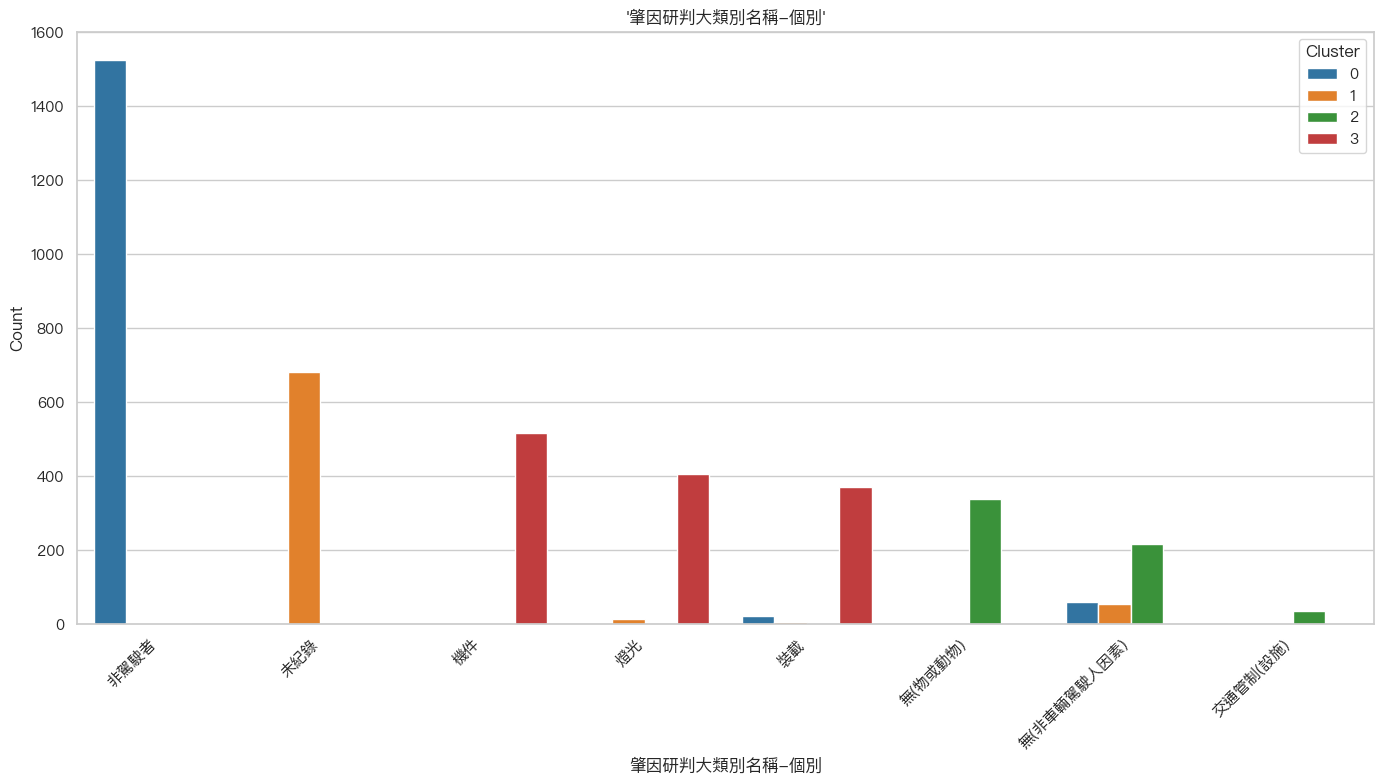

In [27]:
import seaborn as sns
from matplotlib.font_manager import FontProperties

attr = '肇因研判大類別名稱-個別'

myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
sns.set(style="whitegrid", font=myfont.get_name())

plt.figure(figsize=(14, 8))
sns.countplot(
    data=rbind_data,
    x=attr,
    hue='Cluster',  # 按 Cluster 分组显示
    order=rbind_data[attr].value_counts().index,  # 按频率排序
    palette="tab10"
)
plt.title(f"'{attr}'")
plt.xlabel(f"{attr}")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()